In [135]:
# Import Modules
import math
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
import scipy.stats as stats
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from IPython.display import display

In [136]:
# Data Treatment
data_path = "C:/Users/USER/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
#data_path = "C:/Users/bsjun/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
raw_Data= pd.read_excel(data_path,sheet_name="data_for_ML")

display(raw_Data)
MVs = raw_Data[['T_operation','V_operation','E_operation','C_F_LA','C_A_LA']]
CVs = raw_Data[['SEC','J_LA']]

X = MVs.values
Y = CVs.values

,T_operation,V_operation,E_operation,t_operation2,C_F_LA,C_A_LA,C_B_LA,C_F_K,C_A_K,C_B_K,V_F,V_A,V_B,CE,SEC,J_LA,Date,V-C
0,35,35,0.50,2.000000,2.666598,0.272588,-0.000073,2.179980,0.017253,0.686864,1.08,0.98,1.90,15.522230,6.563329,223.608106,230719,32.605990
1,35,35,0.50,2.933333,2.470914,0.577139,0.010599,1.660887,0.027207,1.179806,1.03,1.00,1.93,19.058529,5.408487,543.993190,230719,33.106224
2,35,35,0.50,3.933333,2.193242,1.063021,0.023075,1.109295,0.041413,1.734744,0.78,1.15,2.00,26.182700,3.958080,1056.942907,230719,33.869779
3,35,35,0.50,4.933333,1.570518,1.593019,0.039529,0.649633,0.034028,2.124536,0.58,1.28,2.10,32.334484,3.211235,1337.426543,230719,35.022501
4,35,35,0.50,5.933333,0.258292,2.081178,0.055639,0.096276,0.030335,2.372350,0.28,1.40,2.20,37.264021,2.788854,1432.411229,230719,36.822886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,25,20,0.25,5.000000,0.098302,0.391536,0.007126,0.229102,0.018822,1.198048,0.87,1.06,2.06,31.056335,1.889339,330.756137,220530,20.293234
65,25,20,0.25,6.000000,-0.005371,0.463963,0.013628,0.004460,0.019363,1.230543,0.80,1.10,2.11,38.189885,1.540439,156.134653,220530,20.469334
66,25,10,0.25,19.966667,0.167562,0.263575,0.027605,0.302962,0.025402,1.024611,1.01,0.83,2.09,15.929202,6.357343,22.524709,220527,10.096014
67,25,10,0.25,21.383333,0.139467,0.281049,0.030824,0.282755,0.026824,1.037554,0.99,0.81,2.09,15.937318,6.360940,10.269089,220527,10.141583


In [137]:
# surrogate or approximation for the objective function
def surrogate(model, X):
    # catch any warning generated when making a prediction
    with catch_warnings():
        # ignore generated warnings
        simplefilter('ignore')
        return model.predict(X, return_std=True)

In [138]:
# Expected improvement acquisition function
def acquisition(X, Xsamples, model, xi):
    # calculate the best surrgate score found so far
    yhat, _ = surrogate(model, X)
    best1, best2 = min([i[0] for i in yhat]), max([i[1] for i in yhat])

    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)

    # Calculate the expected improvement (EI)
    # Clip std to avoid division by zero
    std = np.clip(std, 1e-9, None)  # Replace None with a suitable upper bound if needed
    std2 = [i[0] for i in std]
    z = score2 - best / std2
    ei = (score2 - best) * stats.norm.cdf(z) + std2 * stats.norm.pdf(z)
    return ei

In [139]:
# optimize the acquisition function
def opt_acquisition(X, y, model):
    # grid search, generate samples
    Tsample = np.linspace(25,35,31)
    Vsample = np.linspace(10,35,31)
    Esample = np.linspace(0.25,1,31)
    Fsample = np.linspace(-0.1,5.2,31)
    Asample = np.linspace(-0.1,2.2,31)
    Xsamples = np.asarray(list(itertools.product(Tsample,Vsample,Esample,Fsample,Asample)))
    
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = np.argmax(scores)
    return Xsamples[ix]

In [140]:
# plot real observation vs surrogate function
def plot(X, y, model):
    # Split inputs
    Xe1 = [X[i][0] for i in range(len(X))]
    Xe2 = [X[i][1] for i in range(len(X))]
    Xe3 = [X[i][2] for i in range(len(X))]
    ye1 = [y[i][0] for i in range(len(y))]
    ye2 = [y[i][1] for i in range(len(y))]

    # scatter plot of imputs
    fig, axes = plt.subplots(2,3)
    axes[0,0].scatter(Xe1, ye1)
    axes[0,1].scatter(Xe2, ye1)
    axes[0,2].scatter(Xe3, ye1)
    axes[1,0].scatter(Xe1, ye2)
    axes[1,1].scatter(Xe2, ye2)
    axes[1,2].scatter(Xe3, ye2)

    # line plot of surragte function acorss domain
    Xp1 = np.append(Xe1,10 + 10*np.random.random(20))
    Xp2 = np.append(Xe2,2*np.random.random(20))
    Xp3 = np.append(Xe3,-10 + 20*np.random.random(20))
    Xpred = np.asarray(list(itertools.product(Xp1,Xp2,Xp3)))

    ypred, _ = surrogate(model, Xpred)
    yp1 = [i[0] for i in ypred]
    yp2 = [i[1] for i in ypred]

    Xpl1 = [i[0] for i in Xpred]
    Xpl2 = [i[1] for i in Xpred]
    Xpl3 = [i[2] for i in Xpred]

    axes[0,0].scatter(Xpl1, yp1, s=1)
    axes[0,1].scatter(Xpl2, yp1, s=1)
    axes[0,2].scatter(Xpl3, yp1, s=1)
    axes[1,0].scatter(Xpl1, yp2, s=1)
    axes[1,1].scatter(Xpl2, yp2, s=1)
    axes[1,2].scatter(Xpl3, yp2, s=1)
    # show the plot
    plt.show()

In [141]:
T, V, E, FLA, ALA = [i[0] for i in X], [i[1] for i in X], [i[2] for i in X], [i[3] for i in X], [i[4] for i in X]
SEC, JLA = [i[0] for i in Y], [i[1] for i in Y]

# Z-score normalization
zX = list(range(len(X)))
zY = list(range(len(Y)))

for i in range(len(zX)):
    iX = [(T[i]-np.average(T))/np.std(T),(V[i]-np.average(V))/np.std(V),(E[i]-np.average(E))/np.std(E),(FLA[i]-np.average(FLA))/np.std(FLA),(ALA[i]-np.average(ALA))/np.std(ALA)]
    iY = [(SEC[i]-np.average(SEC))/np.std(SEC),(JLA[i]-np.average(JLA))/np.std(JLA)]
    zX[i], zY[i] = iX, iY
zX, zY = np.asarray(zX), np.asarray(zY)

# min-max normalization
mX = list(range(len(X)))
mY = list(range(len(Y)))

for i in range(len(mX)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(FLA[i]-np.min(FLA))/(np.max(FLA)-np.min(FLA)),(ALA[i]-np.min(ALA))/(np.max(ALA)-np.min(ALA))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mX[i], mY[i] = iX, iY
mX, mY = np.asarray(mX), np.asarray(mY)

thr = np.inf
thr1 = thr
thr2 = -thr
over_thr1 = np.where(np.asarray([i[0] for i in zY]) > thr1)
over_thr2 = np.where(np.asarray([i[1] for i in zY]) > thr1)
over_thr3 = np.where(np.asarray([i[0] for i in zY]) < thr2)
over_thr4 = np.where(np.asarray([i[1] for i in zY]) < thr2)
over_thr = np.unique(np.concatenate((np.asarray(over_thr1)[0], np.asarray(over_thr2)[0], np.asarray(over_thr3)[0], np.asarray(over_thr4)[0])))
rzX = zX[~np.isin(np.arange(zX.shape[0]), over_thr), :]
rzY = zY[~np.isin(np.arange(zY.shape[0]), over_thr), :]

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(mX,mY,test_size = 0.2, random_state=42)

# 5-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state= 42)

mse_scores_1 = []
mse_scores_2 = []
alp1 = 0.008
alp2 = 0.008
for train_index, test_index in kfold.split(X_train):
    X_train2, X_test2 = X_train[train_index], X_train[test_index]
    Y_train2, Y_test2 = Y_train[train_index], Y_train[test_index]

    GPR1 = GaussianProcessRegressor(alpha=alp1)
    GPR1.fit(X_train2, [i[0] for i in Y_train2])

    GPR2 = GaussianProcessRegressor(alpha=alp2)
    GPR2.fit(X_train2, [i[1] for i in Y_train2])

    ypred1 = GPR1.predict(X_test2)
    ypred2 = GPR2.predict(X_test2)

    mse_1 = mse(np.asarray([i[0] for i in Y_test2]),ypred1)
    mse_2 = mse(np.asarray([i[1] for i in Y_test2]),ypred2)
    mse_scores_1.append(mse_1)
    mse_scores_2.append(mse_2)

mean_mse_1 = sum(mse_scores_1) / len(mse_scores_1)
mean_mse_2 = sum(mse_scores_2) / len(mse_scores_2)

print(mean_mse_1)
print(mean_mse_2)


0.017089268359956142
0.0022909299277092095


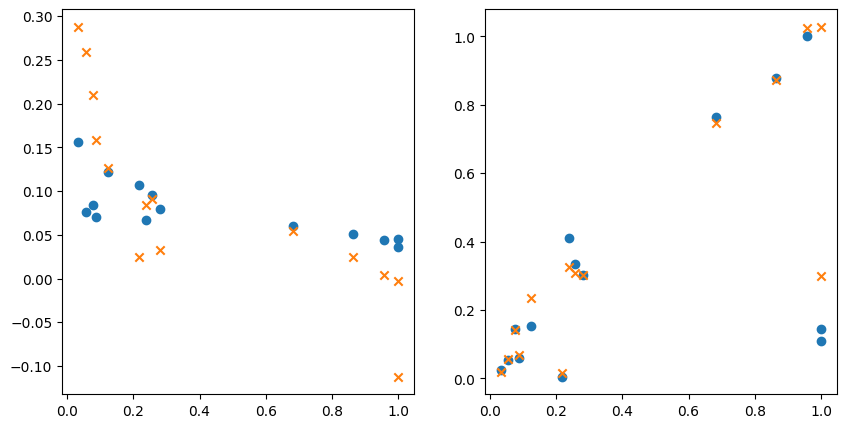

In [142]:
GPR1 = GaussianProcessRegressor(alpha=alp)
GPR1.fit(X_train, [i[0] for i in Y_train])
ypred1,_ = GPR1.predict(X_test,[i[0] for i in Y_test])

GPR2 = GaussianProcessRegressor(alpha=alp)
GPR2.fit(X_train, [i[1] for i in Y_train])
ypred2,_ = GPR2.predict(X_test,[i[1] for i in Y_test])

fig, axs = plt.subplots(1,2, figsize =(10,5))

axs[0].scatter([i[4] for i in X_test],[i[0] for i in Y_test],marker='o')
axs[0].scatter([i[4] for i in X_test],ypred1,marker='x')

axs[1].scatter([i[4] for i in X_test],[i[1] for i in Y_test],marker='o')
axs[1].scatter([i[4] for i in X_test],ypred2,marker='x')

NameError: name 'ypred_f2' is not defined

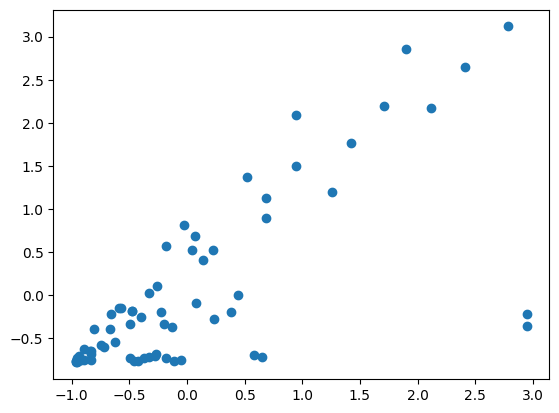

In [143]:
plt.scatter([i[4] for i in rzX],[i[1] for i in rzY],marker='o')
plt.scatter([i[4] for i in rzX],ypred_f2,marker='x')

In [ ]:




T = [i[0] for i in X_train]
V = [i[1] for i in X_train]
E = [i[2] for i in X_train]
F = [i[3] for i in X_train]
A = [i[4] for i in X_train]

SEC = [i[0] for i in Y_train]
JLA = [i[1] for i in Y_train]

rX_train = list(range(len(X_train)))
rY_train = list(range(len(X_train)))

# Z-score normalization
for i in range(len(X_train)):
    iX = [(T[i]-np.average(T))/np.std(T),(V[i]-np.average(V))/np.std(V),(E[i]-np.average(E))/np.std(E),(F[i]-np.average(F))/np.std(F),(A[i]-np.average(A))/np.std(A)]
    iY = [(SEC[i]-np.average(SEC))/np.std(SEC),(JLA[i]-np.average(JLA))/np.std(JLA)]
    rX_train[i] = iX
    rY_train[i] = iY
rX_train = np.asarray(rX_train)
rY_train = np.asarray(rY_train)

model = GaussianProcessRegressor()
model.fit(rX_train,rY_train)

ypred, yunc = model.predict()
# # 5-Fold Cross Validation
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)


# for train_index, val_index in kfold.split(X_train):
#     X_train_fold, X_val_fold = rX_train[train_index], rX_train[val_index]
#     Y_train_fold, Y_val_fold = rY_train[train_index], rY_train[val_index]

#     # 모델 학습
#     model = GaussianProcessRegressor()
#     model.fit(X_train_fold,Y_train_fold)

#     # 예측 및 평가
    




# model = GaussianProcessRegressor()
# model.fit(rX_train,rY_train)

# yhat, _ = surrogate(model, rX_train)
# best1, best2 = min([i[0] for i in yhat]), max([i[1] for i in yhat])

# Ts = np.linspace(25,35,3)
# Vs = np.linspace(10,35,3)
# Es = np.linspace(0.25,1,3)
# Fs = np.linspace(-0.1,5.2,3)
# As = np.linspace(-0.1,2.2,3)
# Xs = np.asarray(list(itertools.product(Ts,Vs,Es,Fs,As)))

# rTs = [i[0] for i in Xs]
# rVs = [i[1] for i in Xs]
# rEs = [i[2] for i in Xs]
# rFs = [i[3] for i in Xs]
# rAs = [i[4] for i in Xs]
# rX_sample = list(range(len(Xs)))
# for i in range(len(rX_sample)):
#     iXs = [(rTs[i]-np.average(rTs))/np.std(rTs),(rVs[i]-np.average(rVs))/np.std(rVs),(rEs[i]-np.average(rEs))/np.std(rEs),(rFs[i]-np.average(rFs))/np.std(rFs),(rAs[i]-np.average(rAs))/np.std(rAs)]
#     rX_sample[i] = iXs

# mu, std = surrogate(model, rX_sample)

# mu1 = [i[0] for i in mu]
# mu2 = [i[1] for i in mu]
# std1 = [i[0] for i in std]
# std2 = [i[1] for i in std]

# rstd1 = np.clip(std1, 1e-9, None)
# rstd2 = np.clip(std2, 1e-9, None)



# print(min(ei2))
# std = np.clip(std, 1e-9, None)  # Replace None with a suitable upper bound if needed
# std2 = [i[0] for i in std]
# z = score2 - best / std2
# ei = (score2 - best) * stats.norm.cdf(z) + std2 * stats.norm.pdf(z)


TypeError: GaussianProcessRegressor.predict() missing 1 required positional argument: 'X'

In [ ]:
mu, std = surrogate(model, Xsamples)


NameError: name 'Xsamples' is not defined

In [ ]:
std

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.

In [ ]:





# 5-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    model = GaussianProcessRegressor()
    model.fit(X_train_fold,Y_train_fold)



# # define the model
# model = GaussianProcessRegressor()
# model.fit(X,y)

# x = opt_acquisition(X, y, model)
# actual = [67.06,49.637]
# est, _ = surrogate(model, [X[2]])
# print(f'>x = {x}, f()={est}, actual={actual}')
# print(np.exp(x[0]),np.exp(x[0])*5)


In [ ]:
# best result
score3=np.zeros(len(y))
for i in range(len(y)):
        score3[i] = eval(y[i])
ix = np.argmin(score3)
print(X[ix], y[ix])

plt.scatter(score3)

,[16.0505649,1.19114408,-0.68813221]
,[67.19,49.637]

<>:10: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<>:11: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<>:10: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?
<>:11: SyntaxWarning: 'list' object is not callable; perhaps you missed a comma?


NameError: name 'y' is not defined